# Features visualization with merge dataset

### Important fuctions

In [1]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pandas as pd
import reverse_geocoder as rg
import geopandas as gpd
import matplotlib.pyplot as plt
import polars as pl
import pandas as pd
import numpy as np
from itertools import combinations
from pathlib import Path
from scipy.stats import entropy

In [2]:
categories = ["child", "pet", "handicap"]

CATEGORY_COLORS = {
    "handicap": "#440d6e",  
    "child": "#31688e",     
    "pet": "#35b779"        
}

In [3]:
def build_dataset_from_final_files(
    df_initial_path: str,
    df_final_path_template: str,
    categories: list[str],
) -> pl.DataFrame:
    """
    Build a merged DataFrame by:
    - loading the original full dataset (df_initial)
    - for each category:
        - load df_final file (to get ids)
        - extract all rows from df_initial with those ids
        - add a column 'category' = category_name
    - concatenate all results (ids can appear multiple times)
    """

    df_initial = pl.read_csv(df_initial_path)

    pieces = []
    for category_name in categories:

        path = df_final_path_template.format(category=category_name)

        try:
            df_final = pl.read_csv(path)
        except Exception as e:
            print(f"  -> Error reading {path}: {e}. Skipping this category.")
            continue

        # Extract ids
        ids = df_final["id"].unique().to_list()

        # Filter original dataset
        df_cat = df_initial.filter(pl.col("id").is_in(ids))

        # Add the category column
        df_cat = df_cat.with_columns(
            pl.lit(category_name).alias("category")
        )

        # Append segment
        pieces.append(df_cat)
        print(f"  -> Added {df_cat.shape[0]} rows for category '{category_name}'")

    # Concatenate everything
    if not pieces:
        print("No pieces collected — returning empty DataFrame")
        return pl.DataFrame()

    df_merged = pl.concat(pieces, how="vertical")
    print(f"\nFinal merged DataFrame: {df_merged.shape[0]} rows, {df_merged.shape[1]} cols")

    return df_merged

In [4]:
def analyze_dataset(df_initial, df_final, categories, features, output_csv, 
                    plot=True, figsize=(16, 10)):
    results_list = []

    n_cat_vs_rest = len(categories) * len(features)
    n_cat_vs_cat = len(list(combinations(categories, 2))) * len(features)
    n_total = n_cat_vs_rest + n_cat_vs_cat
    
    if plot:
        n_cols = 3
        n_rows = (n_total + n_cols - 1) // n_cols 
        fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=figsize)
        axes = axes.flatten() if n_total > 1 else [axes]
        
        for i in range(n_total, len(axes)):
            axes[i].axis('off')
    else:
        axes = [None] * n_total
    
    ax_idx = 0
    
    # ==========================================
    # PARTIE 1 : Category vs Rest
    # ==========================================    
    for category in categories:
        df_cat = df_final.filter(pl.col("category") == category)
        
        for feature in features:
            compare_category_vs_rest(
                df_initial, df_cat, feature, category, results_list,
                ax=axes[ax_idx] if plot else None
            )
            ax_idx += 1
    
    # ==========================================
    # PARTIE 2 : Category vs Category
    # ==========================================
    for cat1, cat2 in combinations(categories, 2):
        df_cat1 = df_final.filter(pl.col("category") == cat1)
        df_cat2 = df_final.filter(pl.col("category") == cat2)
        
        for feature in features:
            compare_two_categories(
                df_cat1, df_cat2, feature, cat1, cat2, results_list,
                ax=axes[ax_idx] if plot else None
            )
            ax_idx += 1
    
    # ==========================================
    # EXPORT CSV
    # ==========================================
    df_results = pd.DataFrame(results_list)
    
    columns_order = [
        "comparison_type", "category", "category2", "feature", "feature_value",
        "proportion_cat1", "proportion_cat2", "difference", 
        "kl_divergence", "js_divergence", "chi_square_distance", "hellinger_distance"
    ]
    df_results = df_results[columns_order]
    
    numeric_cols = ["proportion_cat1", "proportion_cat2", "difference", 
                    "kl_divergence", "js_divergence", "chi_square_distance", "hellinger_distance"]
    df_results[numeric_cols] = df_results[numeric_cols].round(4)
    df_results.to_csv(f"{output_csv}.csv", index=False)

    if plot:
        fig.suptitle(f"Distribution Analysis - Features: {', '.join(features)}", 
                    fontsize=16, weight="bold", y=0.995)
        plt.tight_layout()

        Path("comparaison_metrics").mkdir(parents=True, exist_ok=True)
        fig.savefig(f"{output_csv}.png", dpi=300, bbox_inches="tight")

        plt.show()
    
    return df_results



In [5]:
def compare_two_categories(df_cat1, df_cat2, feature, cat1, cat2, results_list, ax=None):

    dist_cat1 = df_cat1.select(feature).to_pandas()[feature].value_counts(normalize=True)
    dist_cat2 = df_cat2.select(feature).to_pandas()[feature].value_counts(normalize=True)

    all_vals = dist_cat1.index.union(dist_cat2.index)
    dist_cat1 = dist_cat1.reindex(all_vals, fill_value=0)
    dist_cat2 = dist_cat2.reindex(all_vals, fill_value=0)
    
    divergences = calculate_divergences(dist_cat1, dist_cat2)
    
    for val in all_vals:
        results_list.append({
            "comparison_type": "category_vs_category",
            "category": cat1,
            "category2": cat2,
            "feature": feature,
            "feature_value": val,
            "proportion_cat1": dist_cat1[val],
            "proportion_cat2": dist_cat2[val],
            "difference": dist_cat1[val] - dist_cat2[val],
            "kl_divergence": divergences["kl_divergence"],
            "js_divergence": divergences["js_divergence"],
            "chi_square_distance": divergences["chi_square_distance"],
            "hellinger_distance": divergences["hellinger_distance"]
        })

    if ax is not None:
        width = 0.35
        x = range(len(all_vals))
        ax.bar([i - width/2 for i in x], dist_cat1, width=width, 
               label=cat1, color=CATEGORY_COLORS.get(cat1, "blue"))
        ax.bar([i + width/2 for i in x], dist_cat2, width=width, 
               label=cat2, color=CATEGORY_COLORS.get(cat2, "orange"))
        ax.set_xticks(x)
        ax.set_xticklabels(all_vals, rotation=45)
        ax.set_title(f"{cat1} vs {cat2} - {feature}")
        ax.legend()
        


In [6]:
def compare_category_vs_rest(df_initial, df_cat, feature, category, results_list, ax=None):

    dist_cat = df_cat.select(feature).to_pandas()[feature].value_counts(normalize=True)
    dist_rest = df_initial.select(feature).to_pandas()[feature].value_counts(normalize=True)

    all_vals = dist_cat.index.union(dist_rest.index)
    dist_cat = dist_cat.reindex(all_vals, fill_value=0)
    dist_rest = dist_rest.reindex(all_vals, fill_value=0)
    
    divergences = calculate_divergences(dist_cat, dist_rest)
    
    for val in all_vals:
        results_list.append({
            "comparison_type": "category_vs_rest",
            "category": category,
            "category2": "rest",
            "feature": feature,
            "feature_value": val,
            "proportion_cat1": dist_cat[val],
            "proportion_cat2": dist_rest[val],
            "difference": dist_cat[val] - dist_rest[val],
            "kl_divergence": divergences["kl_divergence"],
            "js_divergence": divergences["js_divergence"],
            "chi_square_distance": divergences["chi_square_distance"],
            "hellinger_distance": divergences["hellinger_distance"]
        })

    if ax is not None:
        width = 0.35
        x = range(len(all_vals))
        ax.bar([i - width/2 for i in x], dist_rest, width=width, 
               label="Rest", color="lightgray")
        ax.bar([i + width/2 for i in x], dist_cat, width=width, 
               label=category, color=CATEGORY_COLORS.get(category, "blue"))
        ax.set_xticks(x)
        ax.set_xticklabels(all_vals, rotation=45)
        ax.set_title(f"{category} - {feature}")
        ax.legend()


In [7]:
# Compute of metrics
def calculate_divergences(dist1, dist2):

    eps = 1e-10
    p = dist1.values + eps
    q = dist2.values + eps
    
    p = p / p.sum()
    q = q / q.sum()
    
    # KL Divergence 
    kl_pq = entropy(p, q)
    kl_qp = entropy(q, p)
    kl_divergence = (kl_pq + kl_qp) / 2
    
    # JS Divergence 
    m = (p + q) / 2
    js_divergence = (entropy(p, m) + entropy(q, m)) / 2
    
    # Chi-Square Distance
    chi_square_distance = np.sum((p - q) ** 2 / (q + eps))
    
    # Hellinger Distance
    hellinger_distance = np.sqrt(np.sum((np.sqrt(p) - np.sqrt(q)) ** 2)) / np.sqrt(2)
    
    return {
        "kl_divergence": kl_divergence,
        "js_divergence": js_divergence,
        "chi_square_distance": chi_square_distance,
        "hellinger_distance": hellinger_distance
    }


## Airlines

Les airlines ensemble = guest_type / cities / month of travel / seat type

In [8]:
# Airline Reviews 1
df_initial_path_1 = "../../data/original/dataset/data_airline_reviews_1.csv"
df_final_path_template_1 = "../../data/processed/final/{category}/validated_data_airline_reviews_1_{category}_good.csv"

df_initial_1 = pl.read_csv(df_initial_path_1)
print(f"Dataset : {len(df_initial_1)} lignes")

df_final_1 = build_dataset_from_final_files(
    df_initial_path=df_initial_path_1,
    df_final_path_template=df_final_path_template_1,
    categories=categories
)

Dataset : 3701 lignes
  -> Added 52 rows for category 'child'
  -> Error reading ../../data/processed/final/pet/validated_data_airline_reviews_1_pet_good.csv: Le fichier spécifié est introuvable. (os error 2): ../../data/processed/final/pet/validated_data_airline_reviews_1_pet_good.csv. Skipping this category.
  -> Added 34 rows for category 'handicap'

Final merged DataFrame: 86 rows, 21 cols


In [9]:
# Airline Reviews 2
df_initial_path_2 = "../../data/original/dataset/data_airline_reviews_2.csv"
df_final_path_template_2 = "../../data/processed/final/{category}/validated_data_airline_reviews_2_{category}_good.csv"

df_initial_2 = pl.read_csv(df_initial_path_2)
print(f"Dataset : {len(df_initial_2)} lignes")

df_final_2 = build_dataset_from_final_files(
    df_initial_path=df_initial_path_2,
    df_final_path_template=df_final_path_template_2,
    categories=categories
)

Dataset : 8100 lignes
  -> Added 76 rows for category 'child'
  -> Added 8 rows for category 'pet'
  -> Added 78 rows for category 'handicap'

Final merged DataFrame: 162 rows, 19 cols


### Rename the columns

In [10]:
rename_map_1 = {
    "TypeOfTraveller": "guest_type",
    "DateFlown": "month",
    "Route": "cities",
    "SeatType": "seat_type"
}

rename_map_2 = {
    "Type of Traveller": "guest_type",
    "Month Flown": "month",
    "Route": "cities",
    "Class": "seat_type"
}

df_initial_1 = df_initial_1.rename(rename_map_1)
df_final_1 = df_final_1.rename(rename_map_1)

df_initial_2 = df_initial_2.rename(rename_map_2)
df_final_2 = df_final_2.rename(rename_map_2)

In [11]:
import polars as pl

def harmonize_date_column(df, possible_columns=["month"], new_col="review_date"):
    """
    Cherche la première colonne existante dans `possible_columns`, la convertit en date,
    et crée une colonne `review_date` standard. 
    Ajoute aussi le mois dans une colonne `month`.
    """
    for col in possible_columns:
        if col in df.columns:
            df = (df
                  .with_columns(pl.col(col).str.strptime(pl.Date, format="%B %Y", strict=False).alias(new_col))
                  .with_columns(pl.col(new_col).dt.month().alias("month"))
            )
            return df
    raise ValueError(f"Aucune des colonnes possibles {possible_columns} n'existe dans le DataFrame.")


In [12]:
# Dataset 1
df_initial_1 = harmonize_date_column(df_initial_1)
df_final_1 = harmonize_date_column(df_final_1)

# Dataset 2
df_initial_2 = harmonize_date_column(df_initial_2)
df_final_2 = harmonize_date_column(df_final_2)


In [13]:
columns_to_keep = ["guest_type", "cities", "month", "seat_type", "category"]

def harmonize_columns(df: pl.DataFrame, columns: list) -> pl.DataFrame:
    for col in columns:
        if col not in df.columns:
            df = df.with_columns(pl.lit(None).alias(col))
    return df.select(columns)


# Pour les initial (category peut manquer)
df_initial_1_sel = harmonize_columns(df_initial_1, columns_to_keep)
df_initial_2_sel = harmonize_columns(df_initial_2, columns_to_keep)

# Pour les final (category existe déjà)
df_final_1_sel = df_final_1.select(columns_to_keep)
df_final_2_sel = df_final_2.select(columns_to_keep)

# Concaténer
df_initial = pl.concat([df_initial_1_sel, df_initial_2_sel])
df_final   = pl.concat([df_final_1_sel, df_final_2_sel])


In [14]:
def prepare_cities(df: pl.DataFrame, merge_map: dict) -> pl.DataFrame:
    """
    - Extrait les villes depuis la colonne 'Route'.
    - Applique merge_map pour harmoniser les noms.
    - Explose la liste pour avoir une ligne par ville.
    - Ne fait pas de regroupement 'Other'.
    """
    def extract_cities(route: str):
        if route is None:
            return []
        parts = route.split(" to ")
        cities = []
        for part in parts:
            subparts = part.split(" via ")
            cities.extend([s.strip() for s in subparts])
        return cities

    df_expanded = (
        df.filter(pl.col("cities").is_not_null())
          .with_columns(
              pl.col("cities")
              .map_elements(extract_cities, return_dtype=pl.List(pl.Utf8))
              .alias("cities_split")
          )
          .explode("cities_split")
          .with_columns(
              pl.col("cities_split")
              .map_elements(lambda x: merge_map.get(x, x) if x is not None else None)
              .alias("cities_display")
          )
    )
    
    return df_expanded


In [15]:
merge_map = {
    "London Heathrow": "London",
    "London Gatwick": "London",
    "Heathrow": "London",
    "LGW": "London",
    "LHR": "London",
    "New York JFK": "New York",
    "NYC": "New York",
    "New York": "New York",
    "JFK": "New York",
    "PHL": "Philadelphia", 
    "MIA": "Miami",
    "Miami": "Miami",
    "Orlando MCO": "Orlando",
    "Orlando": "Orlando",
    "MCO": "Orlando",
    "SIN": "Singapore",
    "Singapore": "Singapore",
    "SYD": "Sydney",
    "Sydney": "Sydney",
    "Boston": "Boston",
    "Cairo": "Cairo",
    "Algiers": "Algiers",
    "Gatwick": "London",  
    "Venice": "Venice",
    "Warsaw": "Warsaw",
    "Moscow": "Moscow",
    "Lahore": "Lahore",
    "Delhi": "Delhi",
    "Chennai": "Chennai",
    "Olbia": "Olbia",
    "Gibraltar": "Gibraltar",
    "Budapest": "Budapest",
    "Mahon": "Mahon",
    "Dubai": "Dubai",
    "Cape Town": "Cape Town",
    "Madeira": "Madeira",
    "Alicante": "Alicante",
    "Bergen": "Bergen",
    "Nice": "Nice",
    "PRG": "Prague",
    "PHL": "Philadelphia",
    "AMS": "Amsterdam",
    "BCN": "Barcelona",
    "MCO": "Orlando",
    "IST": "Istanbul",
    "BUD": "Budapest",
    "AGP": "Malaga",
    "MCI": "Kansas City",
    "CDG": "Paris",
    "GIG": "Rio de Janeiro",
    "Denver": "Denver",
    "Frankfurt": "Frankfurt",
    "Mumbai": "Mumbai",
    "Madrid": "Madrid",
    "SÃ£o Paulo": "Sao Paulo",
    "Milan": "Milan",
    "Munich": "Munich",
    "Seattle": "Seattle",
    "Calgary": "Calgary",
    "DÃ¼sseldorf": "Dusseldorf",
    "Seychelles": "Seychelles",
    "Tampa": "Tampa",
    "Brussels": "Brussels",
    "San Diego": "San Diego",
    "ATH": "Athens",
    "GLA": "Glasgow",
    "Rome": "Rome",
    "Pisa": "Pisa",
    "HKG": "Hong Kong",
    "ORD": "Chicago",
    "YVR": "Vancouver",
    "SSH": "Sharm El Sheikh",
    "MEL": "Melbourne",
    "SFO": "San Francisco",
    "DXB": "Dubai",
    "HYD": "Hyderabad"
}

### Guest type

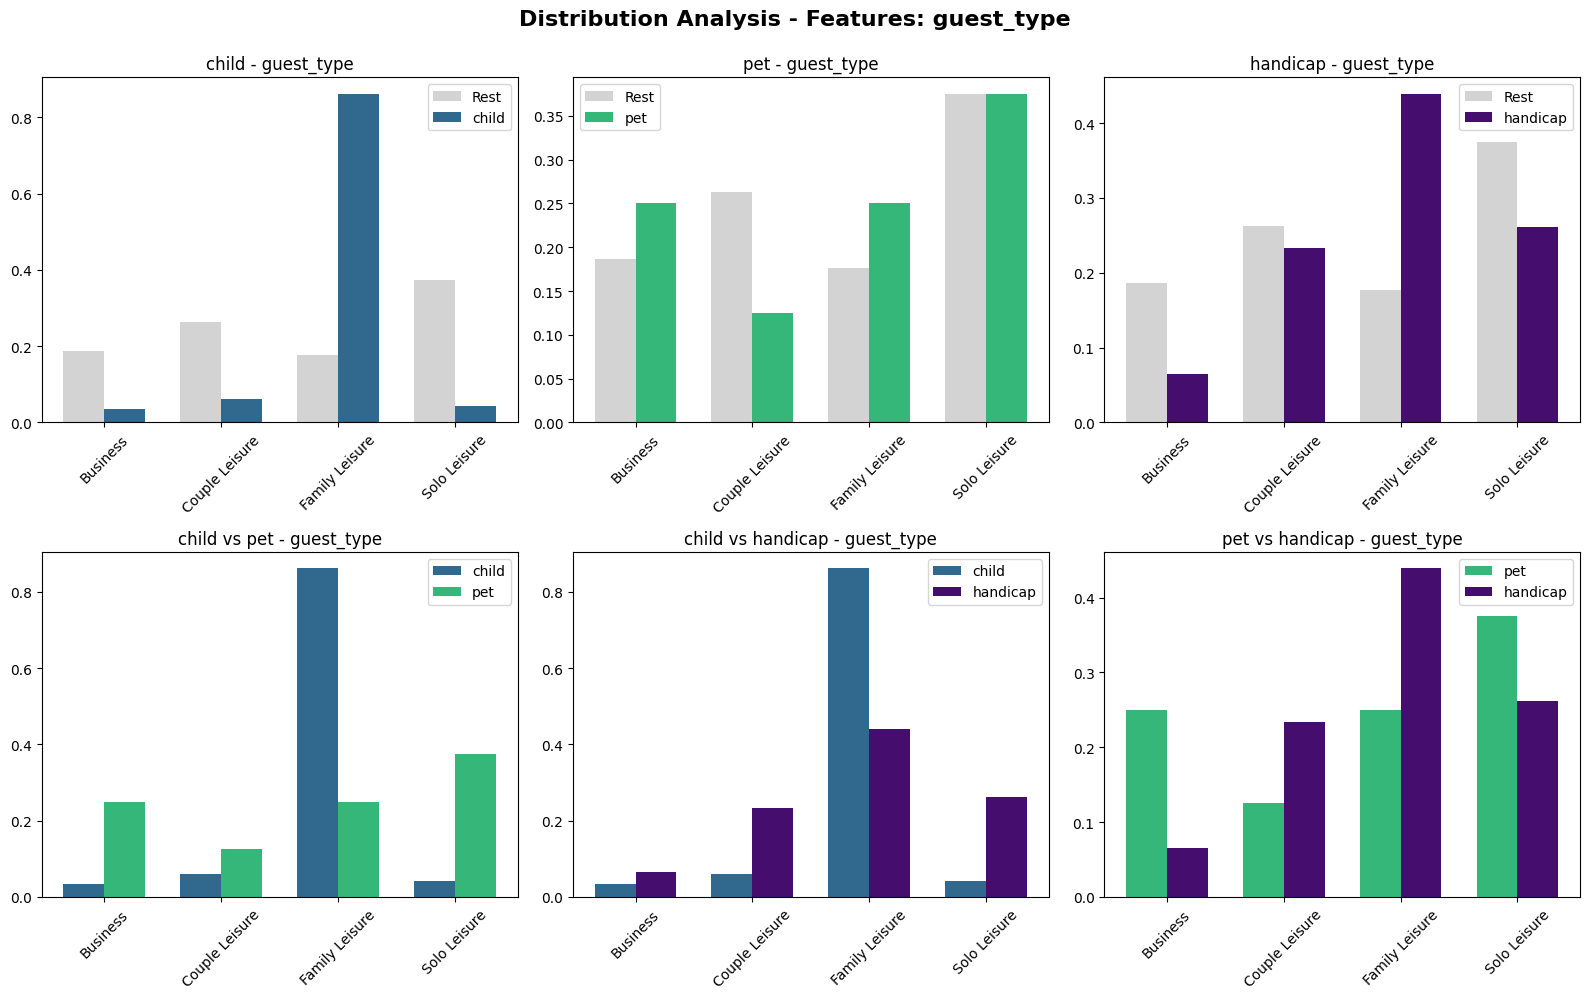

In [16]:
features = ["guest_type"]  
output = "comparaison_metrics/airline_reviews_combined/airline_reviews_combined_guest_type"

df_results = analyze_dataset(
    df_initial=df_initial,
    df_final=df_final,
    categories=categories,
    features=features,
    output_csv=output,
    plot=True,
    figsize=(16, 10)
)

### Month

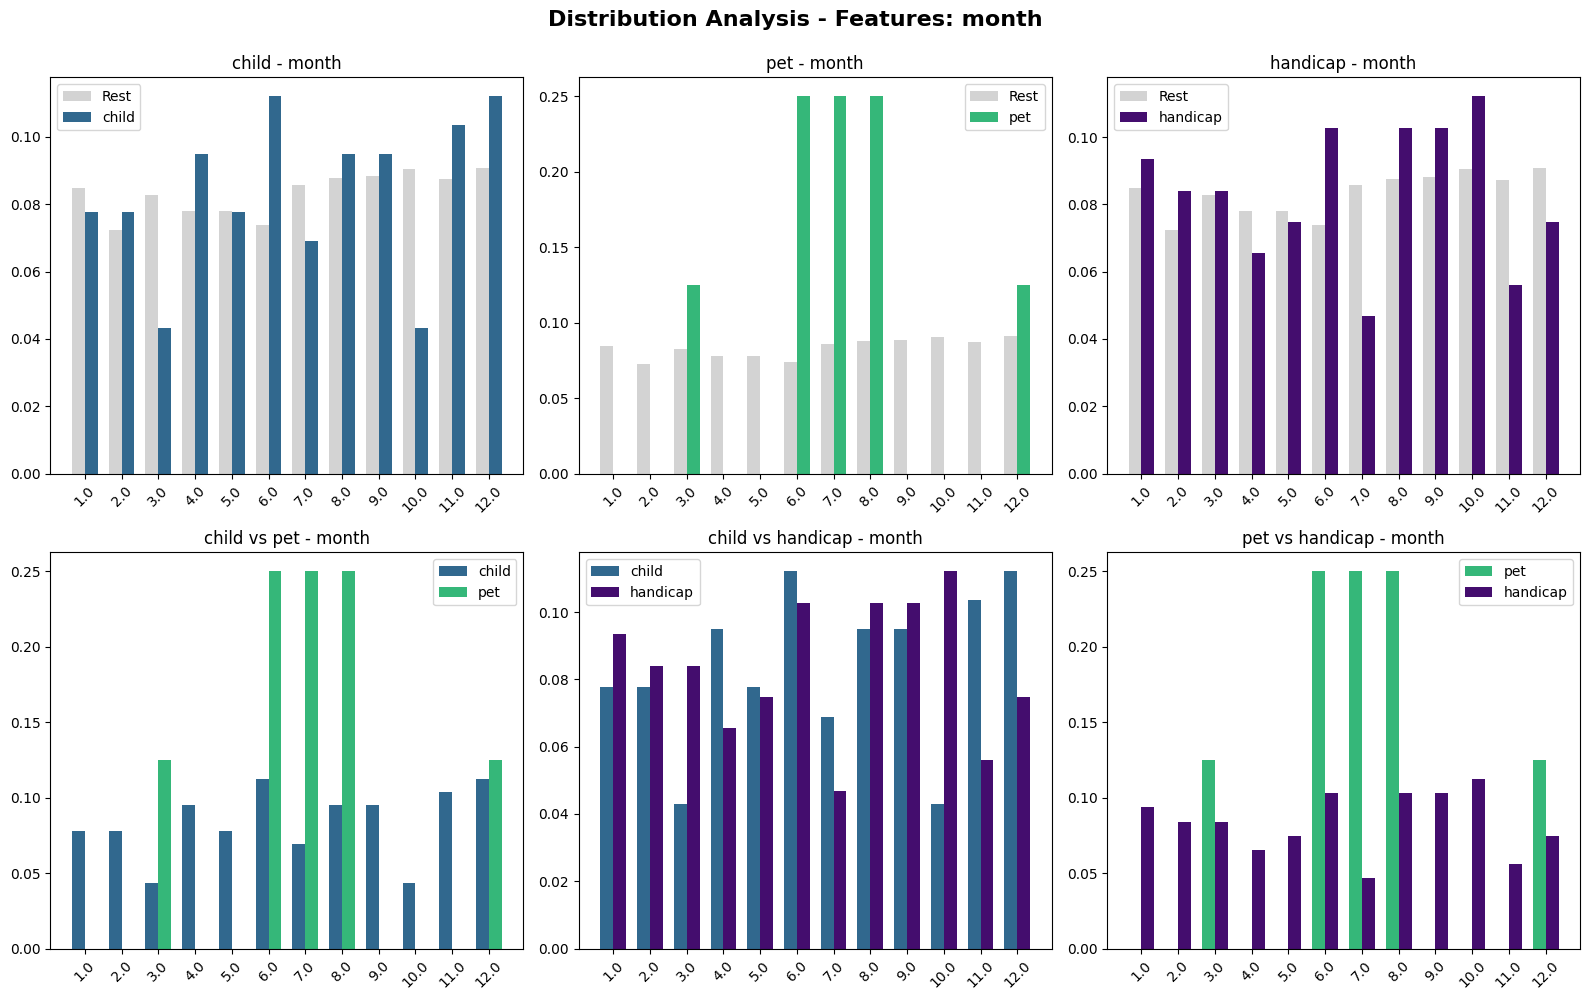

In [17]:
features = ["month"]  
output = "comparaison_metrics/airline_reviews_combined/airline_reviews_combined_month"

df_results = analyze_dataset(
    df_initial=df_initial,
    df_final=df_final,
    categories=categories,
    features=features,
    output_csv=output,
    plot=True,
    figsize=(16, 10)
)


### Route

C:\Users\emma\AppData\Local\Temp\ipykernel_12464\2871913412.py:69: UserWarning: Glyph 153 (\x99) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\emma\AppData\Local\Temp\ipykernel_12464\2871913412.py:69: UserWarning: Glyph 131 (\x83) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\emma\AppData\Local\Temp\ipykernel_12464\2871913412.py:69: UserWarning: Glyph 156 (\x9c) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\emma\AppData\Local\Temp\ipykernel_12464\2871913412.py:69: UserWarning: Glyph 129 (\x81) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\emma\AppData\Local\Temp\ipykernel_12464\2871913412.py:72: UserWarning: Glyph 153 (\x99) missing from font(s) DejaVu Sans.
  fig.savefig(f"{output_csv}.png", dpi=300, bbox_inches="tight")
C:\Users\emma\AppData\Local\Temp\ipykernel_12464\2871913412.py:72: UserWarning: Glyph 131 (\x83) missing from font(s) DejaVu Sans.
  fig.savefig(f"{output_csv}.png", dpi=300, bbox_inches="tight")


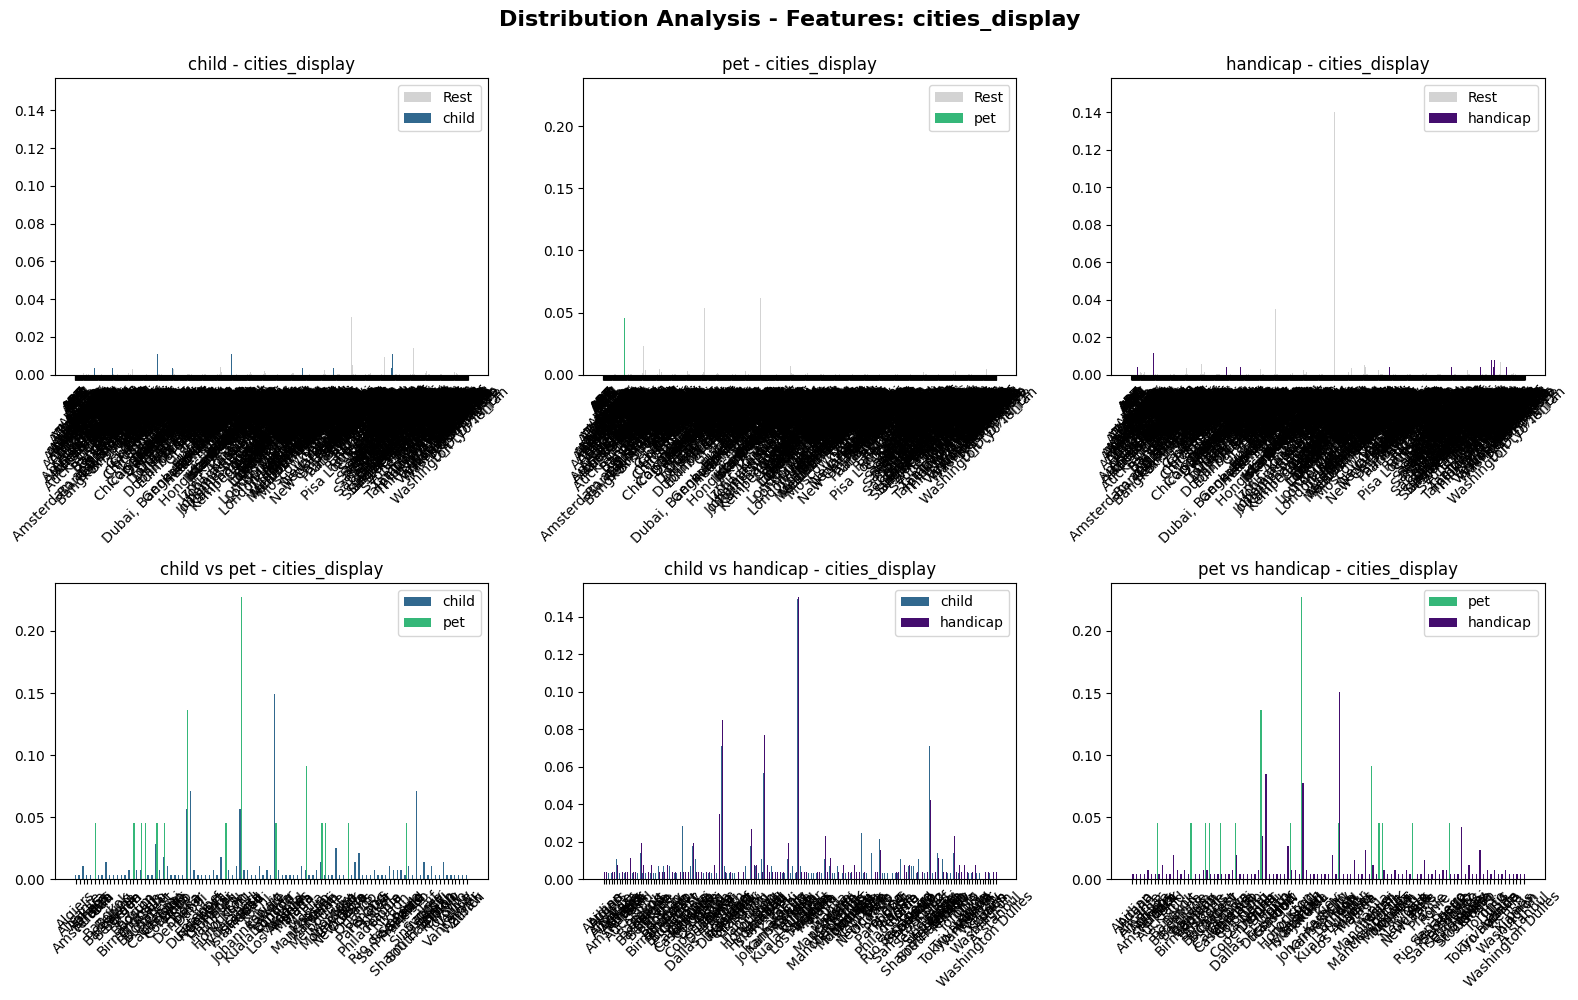

In [18]:
df_initial_cities = prepare_cities(df_initial, merge_map)
df_final_cities   = prepare_cities(df_final, merge_map)

features = ["cities_display"]
output = "comparaison_metrics/airline_reviews_combined/airline_reviews_combined_cities"

df_results = analyze_dataset(
    df_initial=df_initial_cities,
    df_final=df_final_cities,
    categories=categories,
    features=features,
    output_csv=output,
    plot=True,
    figsize=(16, 10)
)

### Seat type

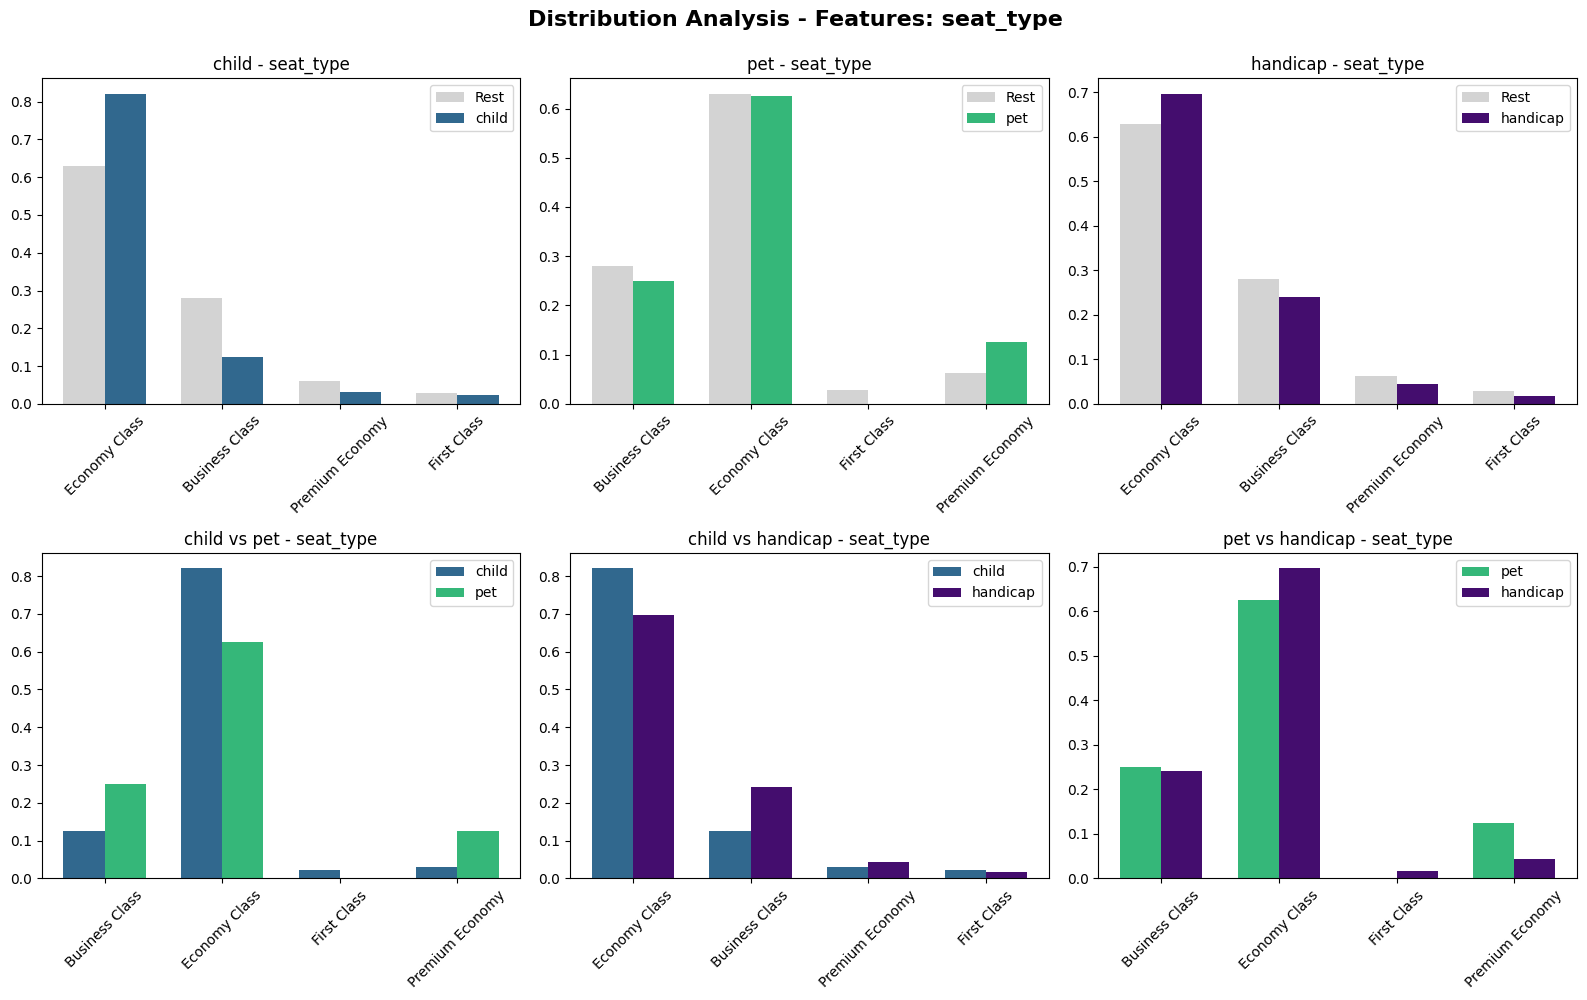

In [19]:
features = ["seat_type"]  
output = "comparaison_metrics/airline_reviews_combined/airline_reviews_combined_seat_type"
    
df_results = analyze_dataset(
    df_initial=df_initial,
    df_final=df_final,
    categories=categories,
    features=features,
    output_csv=output,
    plot=True,
    figsize=(16, 10)
)

### Visualization

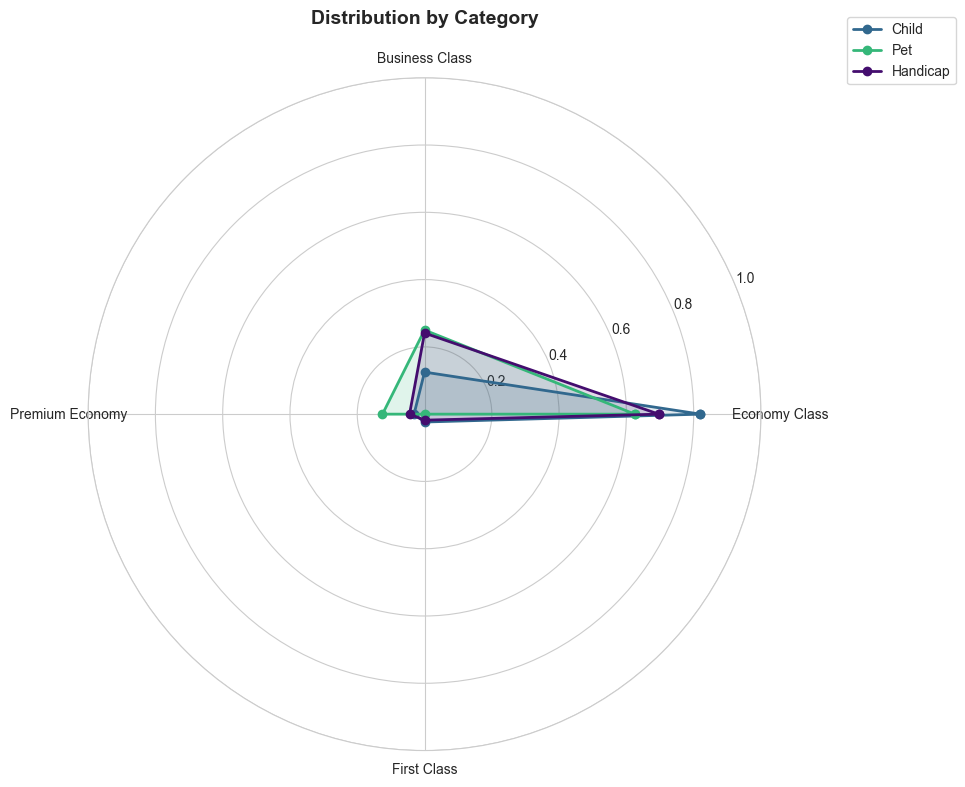

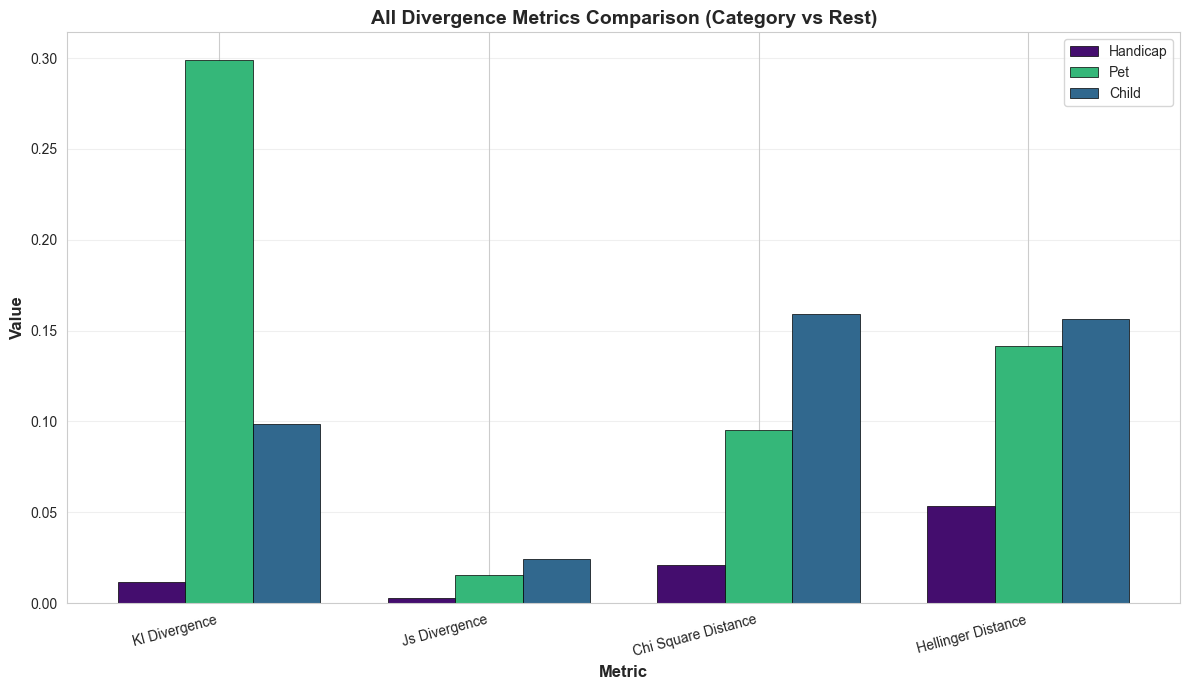

In [20]:
# Configuration
sns.set_style("whitegrid")
CATEGORY_COLORS = {
    "handicap": "#440d6e",
    "child": "#31688e",
    "pet": "#35b779"
}

# Charger les données
path = "comparaison_metrics/airline_reviews_combined/airline_reviews_combined_seat_type"

df = pd.read_csv(f"{path}.csv")


# ==============================================================================
# VIZ 3 : Radar chart des proportions par catégorie
# ==============================================================================
def viz_radar_proportions(df):
    """Radar chart montrant le profil de chaque catégorie"""
    
    df_vs_rest = df[df['comparison_type'] == 'category_vs_rest'].copy()
    categories = df_vs_rest['category'].unique()
    guest_types = df_vs_rest['feature_value'].unique()
    
    # Nombre de variables
    num_vars = len(guest_types)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]  # Fermer le cercle
    
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
    
    for category in categories:
        df_cat = df_vs_rest[df_vs_rest['category'] == category]
        values = df_cat.set_index('feature_value')['proportion_cat1'].reindex(guest_types).tolist()
        values += values[:1]  # Fermer le cercle
        
        ax.plot(angles, values, 'o-', linewidth=2, 
                label=category.capitalize(), 
                color=CATEGORY_COLORS.get(category, 'blue'))
        ax.fill(angles, values, alpha=0.15, color=CATEGORY_COLORS.get(category, 'blue'))
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(guest_types, size=10)
    ax.set_ylim(0, 1)
    ax.set_title('Distribution by Category', 
                 size=14, weight='bold', pad=20)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    ax.grid(True)
    
    plt.tight_layout()
    plt.savefig(f'{path}_radar.png', dpi=300, bbox_inches='tight')
    plt.show()
    

# ==============================================================================
# VIZ 7 : Comparaison toutes métriques (bar plot)
# ==============================================================================
def viz_all_metrics_comparison(df):
    """Bar plot groupé de toutes les métriques pour category vs rest"""
    
    df_vs_rest = df[df['comparison_type'] == 'category_vs_rest'].copy()
    df_unique = df_vs_rest.groupby('category').first().reset_index()
    
    metrics = ['kl_divergence', 'js_divergence', 'chi_square_distance', 'hellinger_distance']
    
    fig, ax = plt.subplots(figsize=(12, 7))
    
    x = np.arange(len(metrics))
    width = 0.25
    
    for i, category in enumerate(['handicap', 'pet', 'child']):
        values = df_unique[df_unique['category'] == category][metrics].values[0]
        offset = width * (i - 1)
        ax.bar(x + offset, values, width, label=category.capitalize(),
               color=CATEGORY_COLORS[category], edgecolor='black', linewidth=0.5)
    
    ax.set_xlabel('Metric', fontsize=12, weight='bold')
    ax.set_ylabel('Value', fontsize=12, weight='bold')
    ax.set_title('All Divergence Metrics Comparison (Category vs Rest)', 
                 fontsize=14, weight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([m.replace('_', ' ').title() for m in metrics], rotation=15, ha='right')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'{path}_metrique.png', dpi=300, bbox_inches='tight')
    plt.show()
    

# ==============================================================================
# SCRIPT PRINCIPAL
# ==============================================================================
if __name__ == "__main__":
    
    viz_radar_proportions(df)
    print()
    
    viz_all_metrics_comparison(df)
    print()

## Hotel Reviews

Les hotels reviews ensemble = accommodation_type / month / country

In [21]:
# Hotel Reviews 1
df_initial_path_1 = "../../data/original/dataset/data_hotel_reviews_1.csv"
df_final_path_template_1 = "../../data/processed/final/{category}/validated_data_hotel_reviews_1_{category}_good.csv"

df_initial_1 = pl.read_csv(df_initial_path_1)
print(f"Dataset : {len(df_initial_1)} rows")

df_final_1 = build_dataset_from_final_files(
    df_initial_path=df_initial_path_1,
    df_final_path_template=df_final_path_template_1,
    categories=categories
)

Dataset : 35912 rows
  -> Added 93 rows for category 'child'
  -> Added 61 rows for category 'pet'
  -> Added 46 rows for category 'handicap'

Final merged DataFrame: 200 rows, 21 cols


In [22]:
# Hotel Reviews 2
df_initial_path_2 = "../../data/original/dataset/data_hotel_reviews_2.csv"
df_final_path_template_2 = "../../data/processed/final/{category}/validated_data_hotel_reviews_2_{category}_good.csv"

df_initial_2 = pl.read_csv(df_initial_path_2)
print(f"Dataset : {len(df_initial_2)} rows")

df_final_2 = build_dataset_from_final_files(
    df_initial_path=df_initial_path_2,
    df_final_path_template=df_final_path_template_2,
    categories=categories
)

Dataset : 10000 rows
  -> Added 51 rows for category 'child'
  -> Added 58 rows for category 'pet'
  -> Added 45 rows for category 'handicap'

Final merged DataFrame: 154 rows, 27 cols


In [23]:
# Hotel Reviews 3
df_initial_path_3 = "../../data/original/dataset/data_hotel_reviews_3.csv"
df_final_path_template_3 = "../../data/processed/final/{category}/validated_data_hotel_reviews_3_{category}_good.csv"

df_initial_3 = pl.read_csv(df_initial_path_3)
print(f"Dataset : {len(df_initial_3)} rows")

df_final_3 = build_dataset_from_final_files(
    df_initial_path=df_initial_path_3,
    df_final_path_template=df_final_path_template_3,
    categories=categories
)

Dataset : 10000 rows
  -> Added 29 rows for category 'child'
  -> Added 66 rows for category 'pet'
  -> Added 49 rows for category 'handicap'

Final merged DataFrame: 144 rows, 27 cols


In [24]:
# booking
df_initial_path_booking = "../../data/original/dataset/data_booking.csv"
df_final_path_template_booking = "../../data/processed/final/{category}/validated_data_booking_{category}_good.csv"

df_initial_booking = pl.read_csv(df_initial_path_booking)
print(f"Dataset : {len(df_initial_3)} rows")

df_final_booking = build_dataset_from_final_files(
    df_initial_path=df_initial_path_booking,
    df_final_path_template=df_final_path_template_booking,
    categories=categories
)

Dataset : 10000 rows
  -> Added 224 rows for category 'child'
  -> Added 108 rows for category 'pet'
  -> Added 79 rows for category 'handicap'

Final merged DataFrame: 411 rows, 18 cols


### Rename the columns

In [25]:
rename_map_1 = {
    "categories": "accommodation",
    "reviews.date": "month",
    "country": "country"
}

rename_map_2 = {
    "categories": "accommodation",
    "dateAdded": "month",
    "country": "country"
}

rename_map_3 = {
    "categories": "accommodation",
    "dateAdded": "month",
    "country": "country"
}

rename_map_booking = {
    "accommodation_type": "accommodation_type",
    "month": "month",
    "accommodation_country": "country"
}

df_initial_1 = df_initial_1.rename(rename_map_1)
df_final_1 = df_final_1.rename(rename_map_1)

df_initial_2 = df_initial_2.rename(rename_map_2)
df_final_2 = df_final_2.rename(rename_map_2)

df_initial_3 = df_initial_3.rename(rename_map_3)
df_final_3 = df_final_3.rename(rename_map_3)

df_initial_booking = df_initial_booking.rename(rename_map_booking)
df_final_booking = df_final_booking.rename(rename_map_booking)

In [26]:
import polars as pl

def harmonize_date_column(df, possible_columns=["month"], new_col="review_date"):
    """
    Cherche la première colonne existante dans `possible_columns`, la convertit en date,
    et crée une colonne `review_date` standard. 
    Ajoute aussi le mois dans une colonne `month`.
    """
    
    for col in possible_columns:
        if col in df.columns:
            df = (df
                  .with_columns(pl.col(col).str.strptime(pl.Date, format="%Y-%m-%dT%H:%M:%SZ", strict=False).alias(new_col))
                  .with_columns(pl.col(new_col).dt.month().alias("month"))
            )
            return df
    raise ValueError(f"Aucune des colonnes possibles {possible_columns} n'existe dans le DataFrame.")


In [27]:
# Dataset 1
df_initial_1 = harmonize_date_column(df_initial_1)
df_final_1 = harmonize_date_column(df_final_1)

# Dataset 2
df_initial_2 = harmonize_date_column(df_initial_2)
df_final_2 = harmonize_date_column(df_final_2)

# Dataset 3
df_initial_3 = harmonize_date_column(df_initial_3)
df_final_3 = harmonize_date_column(df_final_3)


In [28]:
def preprocess_columns(df: pl.DataFrame) -> pl.DataFrame:
    """
    Applique automatiquement tous les pré-traitements possibles
    en fonction des colonnes disponibles.
    """

    # ==============================
    # 1) Extraction colonne categories
    # ==============================
    if "accommodation" in df.columns:
        df = (
            df
            .with_columns(pl.col("accommodation").str.split(",").alias("categories_split"))
            .explode("categories_split")
            .with_columns(pl.col("categories_split").str.strip_chars().alias("accommodation_type"))
        )

    return df


In [29]:
columns_to_keep = ["accommodation", "accommodation_type", "country", "month", "category"]

def harmonize_columns(df: pl.DataFrame, columns: list) -> pl.DataFrame:

    df = preprocess_columns(df)
    
    for col in columns:
        if col not in df.columns:
            df = df.with_columns(pl.lit(None).alias(col))

    df = df.with_columns([
        pl.col(col).cast(pl.Utf8) for col in columns
    ])

    return df.select(columns)


df_initial_1_sel = harmonize_columns(df_initial_1, columns_to_keep)
df_initial_2_sel = harmonize_columns(df_initial_2, columns_to_keep)
df_initial_3_sel = harmonize_columns(df_initial_3, columns_to_keep)
df_initial_booking_sel = harmonize_columns(df_initial_booking, columns_to_keep)

df_final_1_sel      = harmonize_columns(df_final_1,      columns_to_keep)
df_final_2_sel      = harmonize_columns(df_final_2,      columns_to_keep)
df_final_3_sel      = harmonize_columns(df_final_3,      columns_to_keep)
df_final_booking_sel = harmonize_columns(df_final_booking, columns_to_keep)


# df_final_1_sel = df_final_1.select(columns_to_keep)
# df_final_2_sel = df_final_2.select(columns_to_keep)
# df_final_3_sel = df_final_3.select(columns_to_keep)
# df_final_booking_sel = df_final_booking.select(columns_to_keep)

# Concaténer
df_initial = pl.concat([df_initial_1_sel, df_initial_2_sel, df_initial_3_sel, df_initial_booking_sel])
df_final   = pl.concat([df_final_1_sel, df_final_2_sel, df_final_3_sel, df_final_booking_sel])


### Accommodation type

C:\Users\emma\AppData\Local\Temp\ipykernel_12464\2871913412.py:69: UserWarning: Glyph 136 (\x88) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\emma\AppData\Local\Temp\ipykernel_12464\2871913412.py:69: UserWarning: Glyph 154 (\x9a) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\emma\AppData\Local\Temp\ipykernel_12464\2871913412.py:72: UserWarning: Glyph 136 (\x88) missing from font(s) Arial.
  fig.savefig(f"{output_csv}.png", dpi=300, bbox_inches="tight")
C:\Users\emma\AppData\Local\Temp\ipykernel_12464\2871913412.py:72: UserWarning: Glyph 154 (\x9a) missing from font(s) Arial.
  fig.savefig(f"{output_csv}.png", dpi=300, bbox_inches="tight")
c:\Users\emma\Desktop\project\large-project\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 136 (\x88) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\emma\Desktop\project\large-project\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 154 (\x9a) 

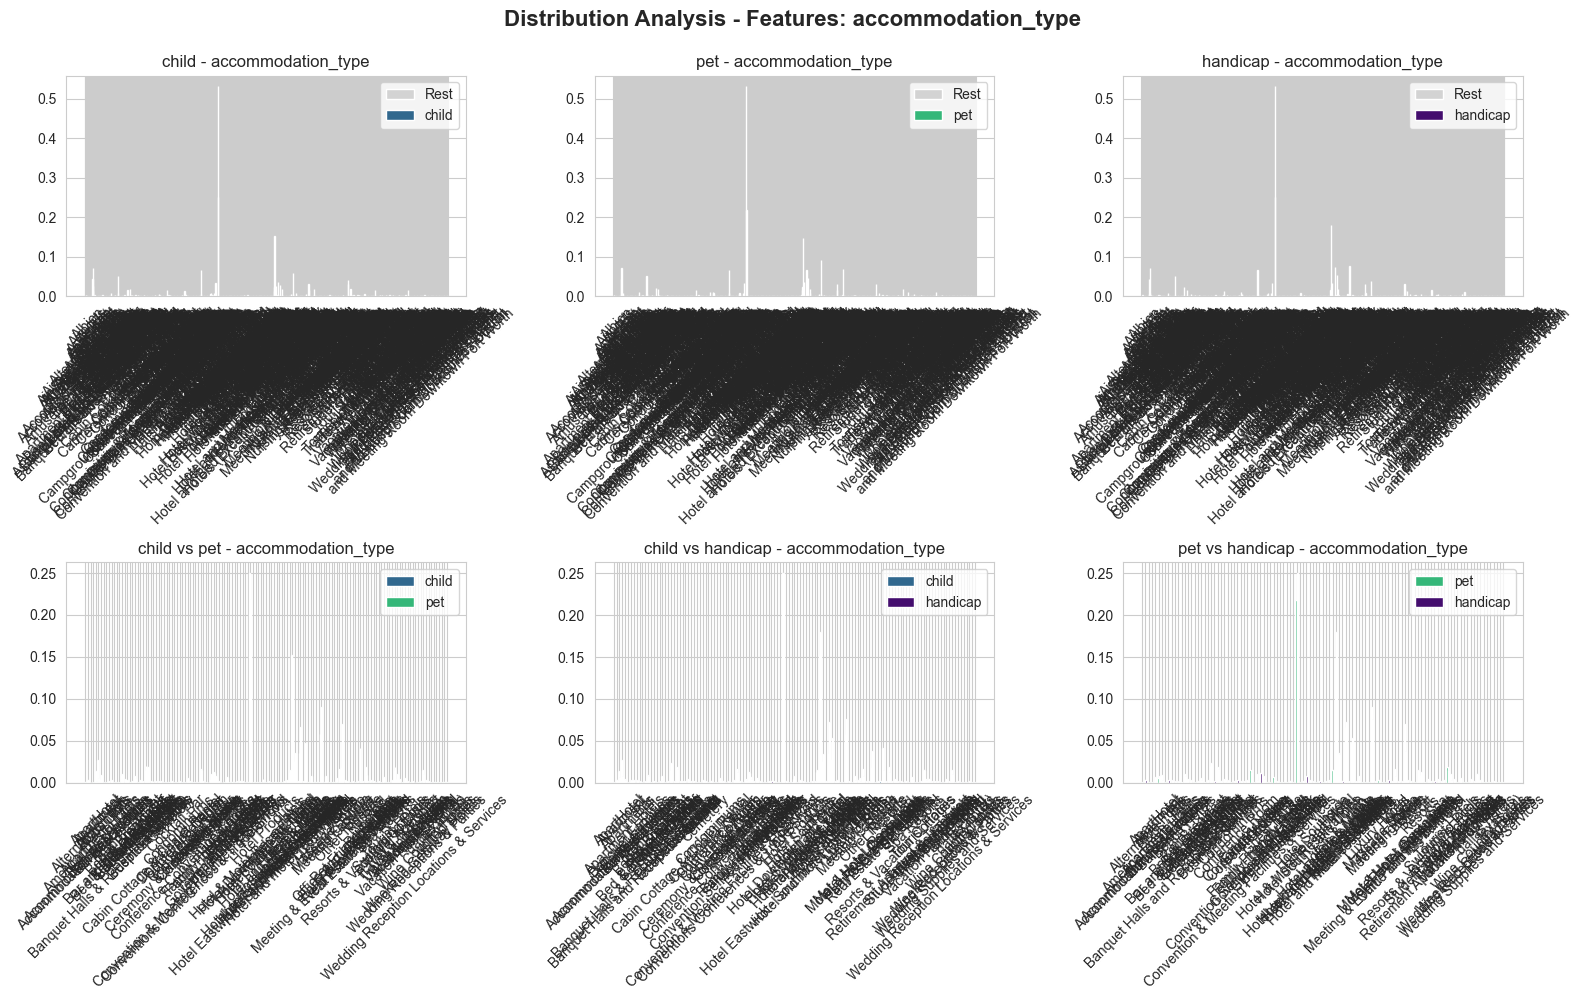

In [30]:
features = ["accommodation_type"]  
output = "comparaison_metrics/hotels_reviews_combined/hotels_reviews_combined_accommodation_type"

df_results = analyze_dataset(
    df_initial=df_initial,
    df_final=df_final,
    categories=categories,
    features=features,
    output_csv=output,
    plot=True,
    figsize=(16, 10)
)

### Month of the travel

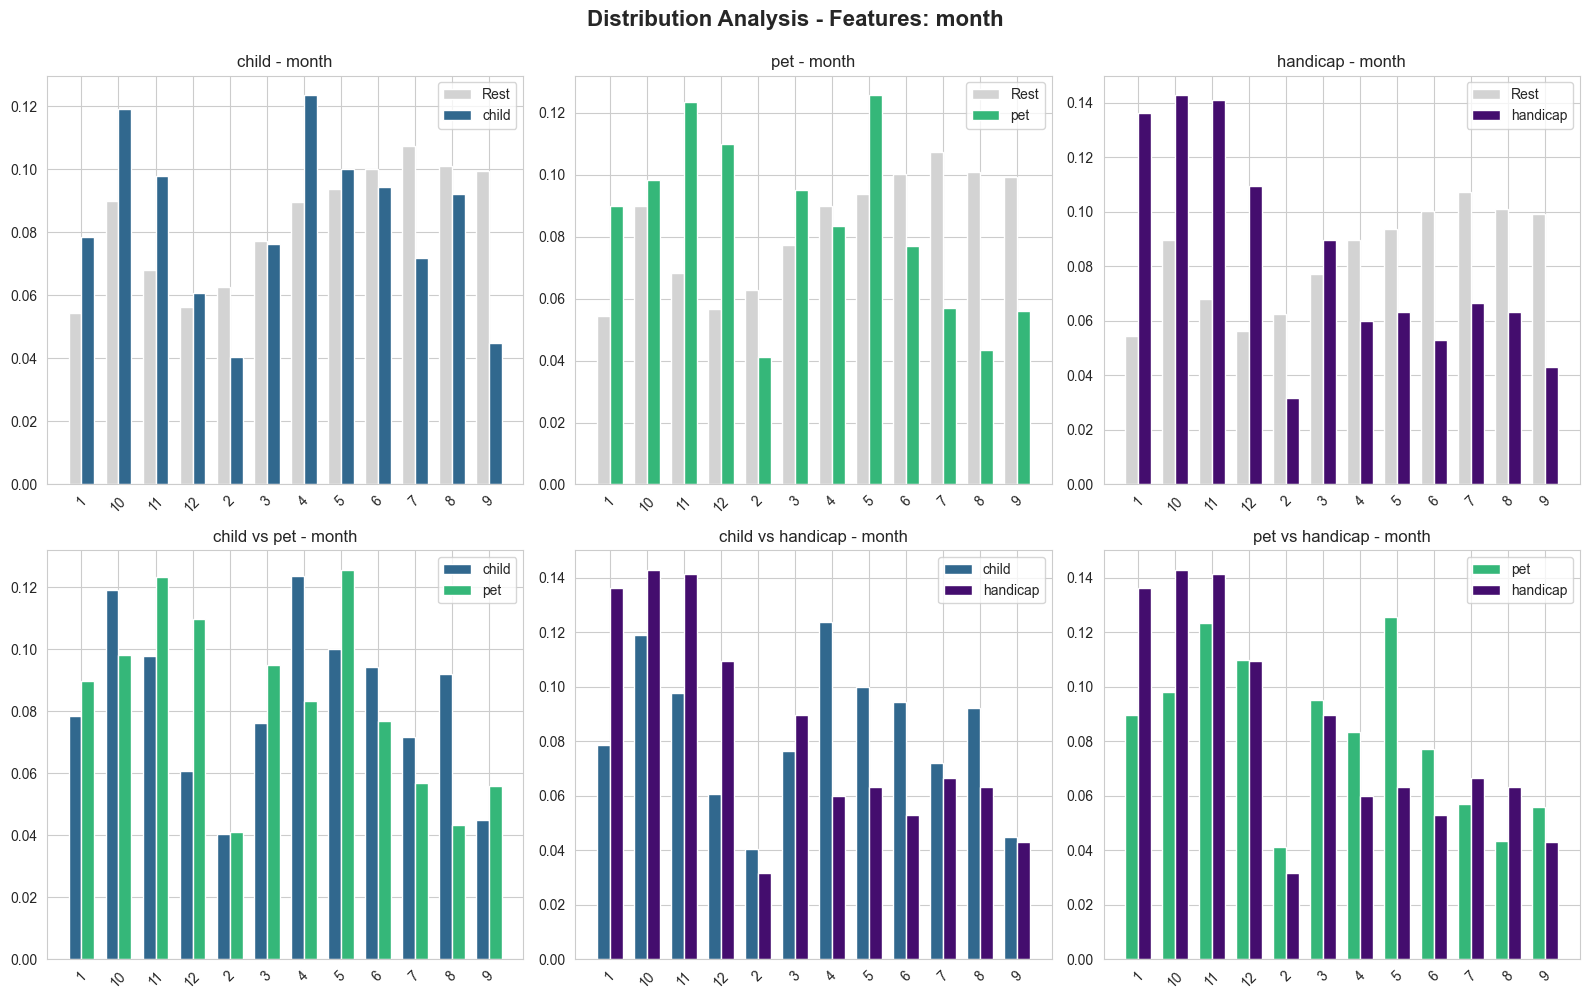

In [31]:
features = ["month"]  
output = "comparaison_metrics/hotels_reviews_combined/hotels_reviews_combined_month"

df_results = analyze_dataset(
    df_initial=df_initial,
    df_final=df_final,
    categories=categories,
    features=features,
    output_csv=output,
    plot=True,
    figsize=(16, 10)
)


### Country 

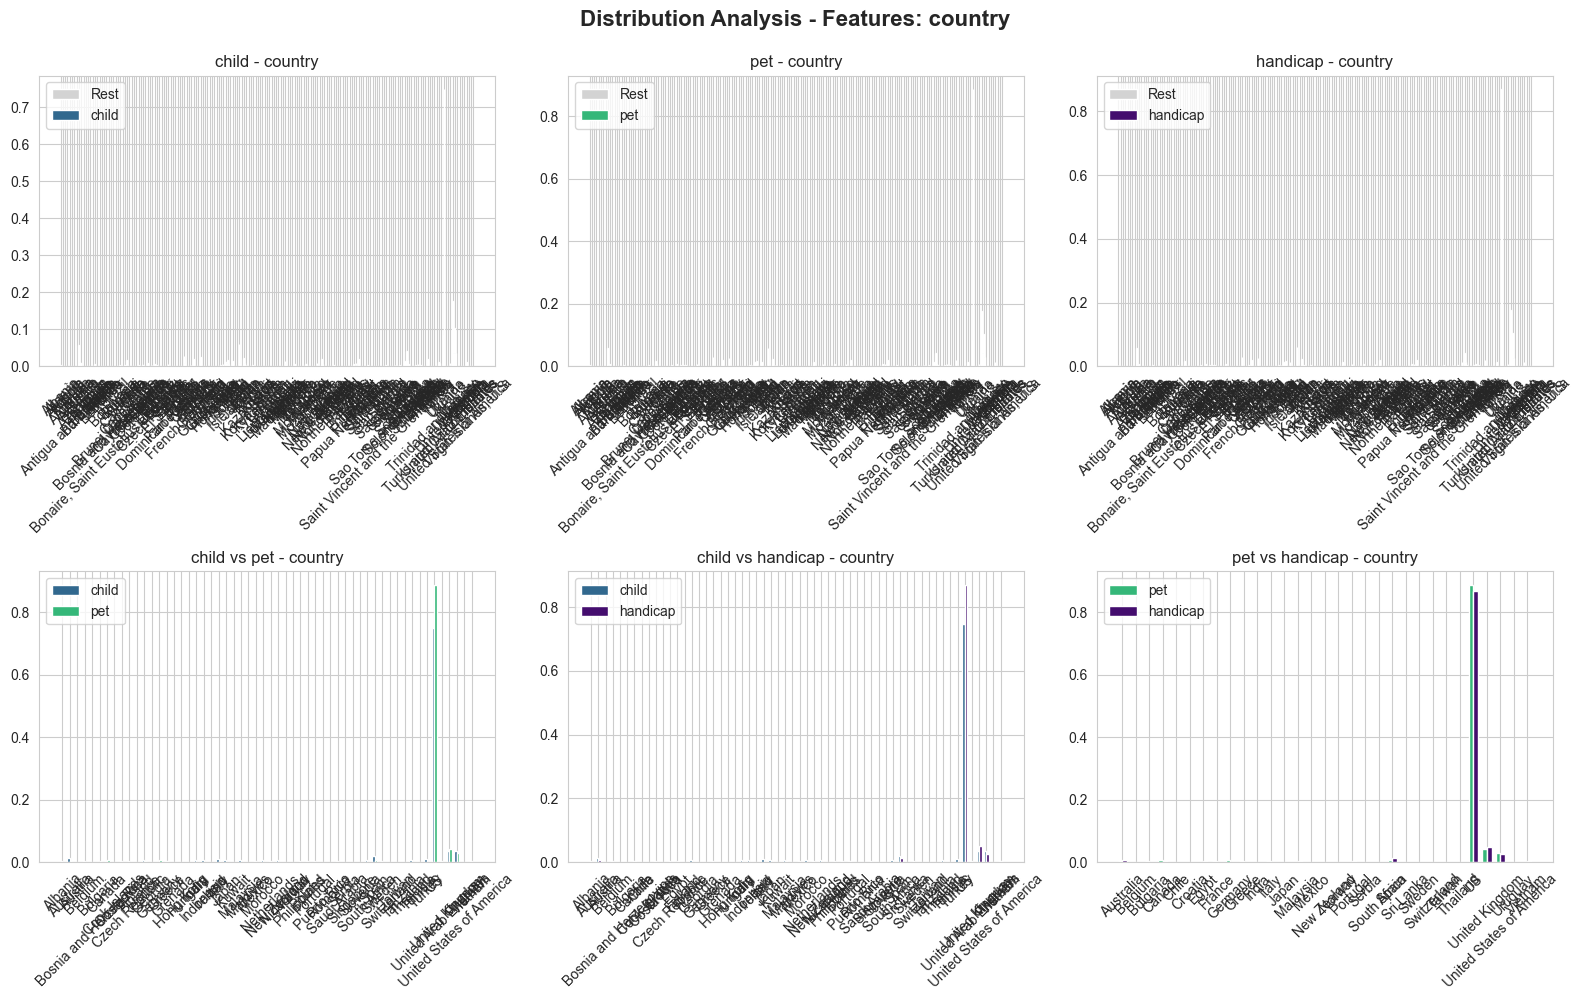

In [44]:
features = ["country"]
output = "comparaison_metrics/hotels_reviews_combined/hotels_reviews_combined_country"

df_results = analyze_dataset(
    df_initial=df_initial,
    df_final=df_final,
    categories=categories,
    features=features,
    output_csv=output,
    plot=True,
    figsize=(16, 10)
)

guest type = airline / european / booking

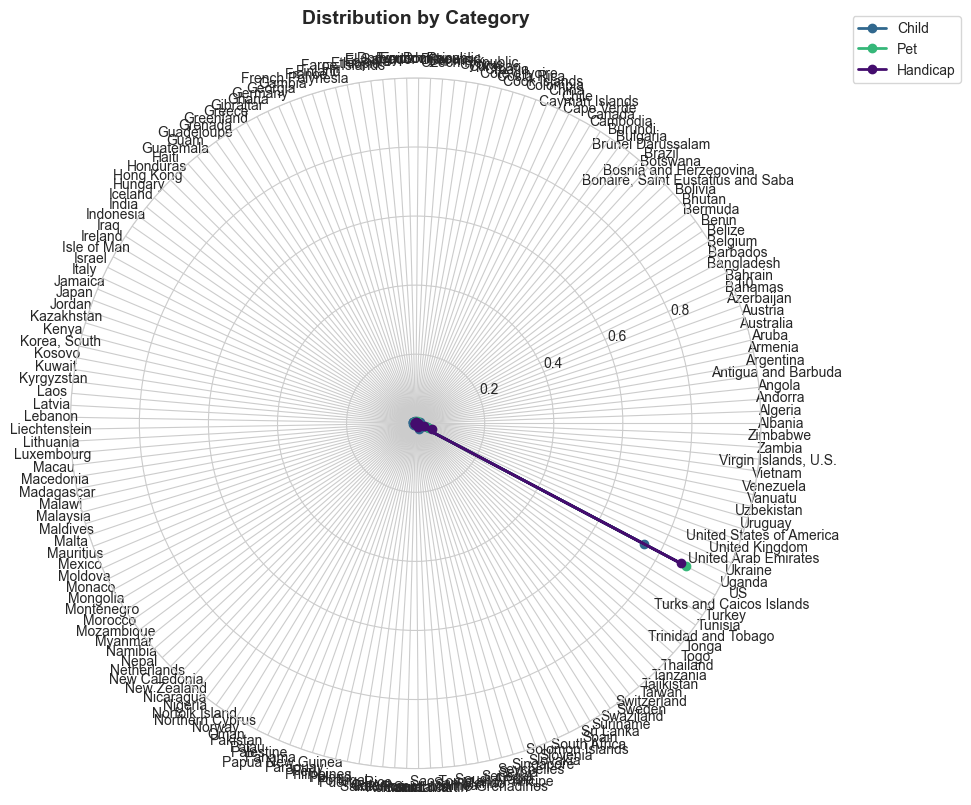

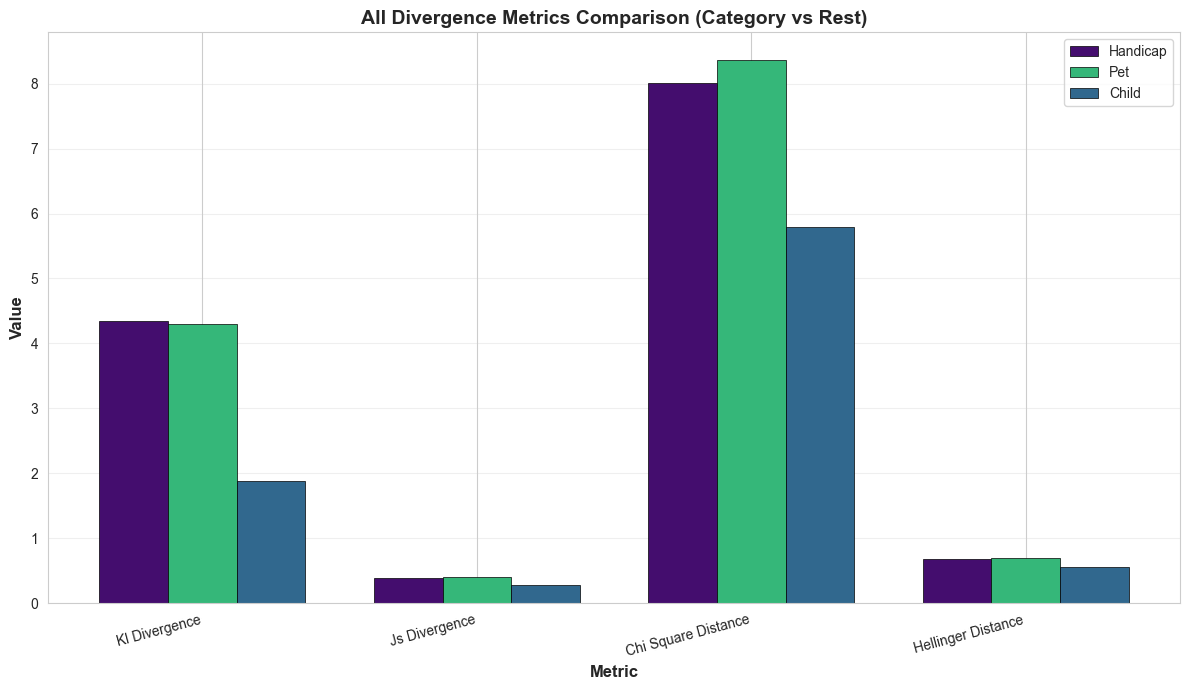

In [45]:
# Configuration
sns.set_style("whitegrid")
CATEGORY_COLORS = {
    "handicap": "#440d6e",
    "child": "#31688e",
    "pet": "#35b779"
}

# Charger les données
path = "comparaison_metrics/hotels_reviews_combined/hotels_reviews_combined_country"

df = pd.read_csv(f"{path}.csv")


# ==============================================================================
# VIZ 3 : Radar chart des proportions par catégorie
# ==============================================================================
def viz_radar_proportions(df):
    """Radar chart montrant le profil de chaque catégorie"""
    
    df_vs_rest = df[df['comparison_type'] == 'category_vs_rest'].copy()
    categories = df_vs_rest['category'].unique()
    guest_types = df_vs_rest['feature_value'].unique()
    
    # Nombre de variables
    num_vars = len(guest_types)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]  # Fermer le cercle
    
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
    
    for category in categories:
        df_cat = df_vs_rest[df_vs_rest['category'] == category]
        values = df_cat.set_index('feature_value')['proportion_cat1'].reindex(guest_types).tolist()
        values += values[:1]  # Fermer le cercle
        
        ax.plot(angles, values, 'o-', linewidth=2, 
                label=category.capitalize(), 
                color=CATEGORY_COLORS.get(category, 'blue'))
        ax.fill(angles, values, alpha=0.15, color=CATEGORY_COLORS.get(category, 'blue'))
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(guest_types, size=10)
    ax.set_ylim(0, 1)
    ax.set_title('Distribution by Category', 
                 size=14, weight='bold', pad=20)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    ax.grid(True)
    
    plt.tight_layout()
    plt.savefig(f'{path}_radar.png', dpi=300, bbox_inches='tight')
    plt.show()
    

# ==============================================================================
# VIZ 7 : Comparaison toutes métriques (bar plot)
# ==============================================================================
def viz_all_metrics_comparison(df):
    """Bar plot groupé de toutes les métriques pour category vs rest"""
    
    df_vs_rest = df[df['comparison_type'] == 'category_vs_rest'].copy()
    df_unique = df_vs_rest.groupby('category').first().reset_index()
    
    metrics = ['kl_divergence', 'js_divergence', 'chi_square_distance', 'hellinger_distance']
    
    fig, ax = plt.subplots(figsize=(12, 7))
    
    x = np.arange(len(metrics))
    width = 0.25
    
    for i, category in enumerate(['handicap', 'pet', 'child']):
        values = df_unique[df_unique['category'] == category][metrics].values[0]
        offset = width * (i - 1)
        ax.bar(x + offset, values, width, label=category.capitalize(),
               color=CATEGORY_COLORS[category], edgecolor='black', linewidth=0.5)
    
    ax.set_xlabel('Metric', fontsize=12, weight='bold')
    ax.set_ylabel('Value', fontsize=12, weight='bold')
    ax.set_title('All Divergence Metrics Comparison (Category vs Rest)', 
                 fontsize=14, weight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([m.replace('_', ' ').title() for m in metrics], rotation=15, ha='right')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'{path}_metrique.png', dpi=300, bbox_inches='tight')
    plt.show()
    

# ==============================================================================
# SCRIPT PRINCIPAL
# ==============================================================================
if __name__ == "__main__":
    
    viz_radar_proportions(df)
    print()
    
    viz_all_metrics_comparison(df)
    print()

## Guest type

In [ ]:
a faire !
